In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf

RANDOM_STATE_SEED = 12

In [3]:
df = pd.read_csv("../datasets/ids-intrusion-csv/02-14-2018.csv")
# replace +ve and -ve infinity with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop missing values
df.dropna(inplace=True)
# make the label as binary classification
df.replace(to_replace=["FTP-BruteForce", "SSH-Bruteforce"], value="Malicious", inplace=True)

In [4]:
#Since there are 380493 instances of Malicious and 663808 instances of Benign, 
#we can take 380493 instances of both Malicious and Benign to train our model 
#with an even class distribution.
df1 = df[df["Label"] == "Benign"][:380943]
df2 = df[df["Label"] == "Malicious"][:380943]
df_equal = pd.concat([ df1,df2], axis =0)

df_equal.replace(to_replace="Benign", value=0, inplace=True)
df_equal.replace(to_replace="Malicious", value=1, inplace=True)

train, test = train_test_split(df_equal, test_size=0.3, random_state=RANDOM_STATE_SEED)

In [5]:
numerical_columns = ['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [6]:
min_max_scaler = MinMaxScaler().fit(train[numerical_columns])
train[numerical_columns] = min_max_scaler.transform(train[numerical_columns])
train.drop(['Timestamp'], axis=1,inplace=True)
test.drop(['Timestamp'],axis=1,inplace=True)
test[numerical_columns] = min_max_scaler.transform(test[numerical_columns])

In [7]:
y_train = np.array(train.pop("Label"))# pop removes "Label" from the dataframe
X_train = train.values

y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
X_test = test.values

In [18]:
X = df_equal.drop(['Label','Timestamp'],axis = 1)
y = df_equal['Label']
X[numerical_columns] = min_max_scaler.transform(X[numerical_columns])

forest = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE_SEED)

# Initialize RFE with 10 features
rfe = RFE(estimator=forest, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get the selected top features
selected_features = rfe.support_
selected_feature_names = train.columns[selected_features]

# Print the selected top features
print("Top 10 selected features:", selected_feature_names)


Top 10 selected features: Index(['Dst Port', 'Flow Pkts/s', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min'],
      dtype='object')


In [19]:
# Evaluate model performance on test data using selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Re-train the model on the reduced feature set
forest.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = forest.predict(X_test_selected)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.9999956248960913
F1 Score: 0.9999956238813547


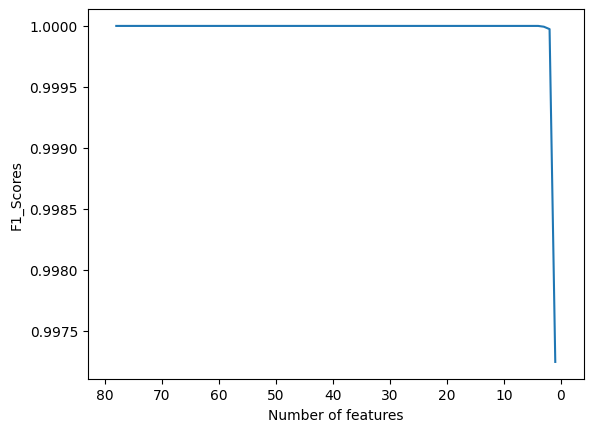

In [10]:
# Plot feature ranking
ranking = rfe.ranking_
plt.figure()
plt.bar(range(len(ranking)), ranking)
plt.xlabel("Feature Index")
plt.ylabel("Ranking")
plt.title("RFE Feature Ranking")
plt.show()

In [21]:
def create_dnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification (malicious or benign)
    ])
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # Use binary cross-entropy for binary classification
                  metrics=['accuracy'])
    
    return model

In [22]:
input_shape = X_train_selected.shape[1]  # Number of selected features
model = create_dnn_model(input_shape)

# Train the model
history = model.fit(X_train_selected, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict on test data
y_pred_prob = model.predict(X_test_selected)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary labels (0 or 1)

# Evaluate the model using accuracy and F1 score
accuracy_dnn = accuracy_score(y_test, y_pred)
f1_dnn = f1_score(y_test, y_pred)

print(f"Accuracy (DNN): {accuracy_dnn}")
print(f"F1 Score (DNN): {f1_dnn}")

Epoch 1/10
13333/13333 [==============================] - 16s 1ms/step - loss: 0.0147 - accuracy: 0.9968 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 2/10
13333/13333 [==============================] - 19s 1ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0021 - val_accuracy: 0.9997
Epoch 3/10
13333/13333 [==============================] - 20s 2ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0018 - val_accuracy: 0.9997
Epoch 4/10
13333/13333 [==============================] - 16s 1ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 8.3763e-04 - val_accuracy: 0.9997
Epoch 5/10
13333/13333 [==============================] - 15s 1ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 3.0050e-04 - val_accuracy: 0.9999
Epoch 6/10
13333/13333 [==============================] - 15s 1ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 2.0202e-04 - val_accuracy: 1.0000
Epoch 7/10
13333/13333 [==============================] - 15s 1ms/step - loss: 8.3487e-04 - accuracy: 0.99

In [23]:
plt.figure(figsize=(12, 4))


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

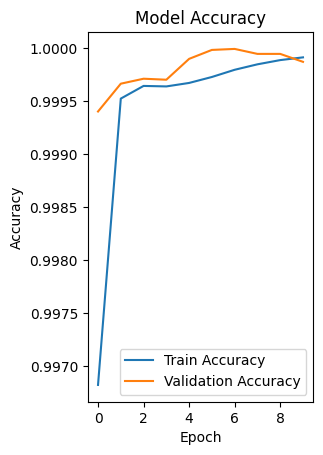

In [24]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

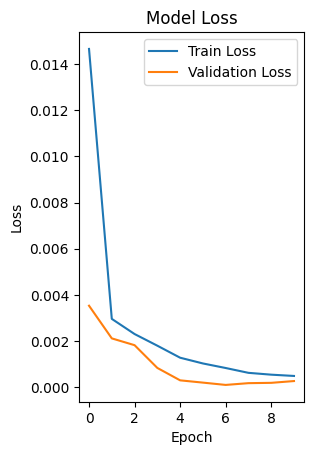

In [25]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [26]:
plt.show()

In [28]:
model.save("dnn_model.keras")